# Resource counts

This notebook computes the resources to calculate the ground state energy of a Hamiltonian to chemical accuracy using three algorithms:

1. VQE
1. Quantum Krylov
1. Quantum phase estimation

## Setup

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import scipy

import openfermion as of
from openfermionpyscf import run_pyscf
from openfermion.chem import geometry_from_pubchem, MolecularData
import openfermion_helper


import qiskit
import qiskit.qasm3
import qiskit_ibm_runtime
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

### OpenFermion helper

## Set Hamiltonian

### From PubChem + OpenFermion

In [2]:
# Set parameters to make a simple molecule.
geometry = geometry_from_pubchem("water")
basis = "sto-3g"
multiplicity = 1
charge = 0

# Make molecule and print out a few interesting facts about it.
molecule = MolecularData(geometry, basis, multiplicity, charge)


mol = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)
mol.save()
water = MolecularData(filename=molecule.filename)
hamiltonian = water.get_molecular_hamiltonian()
hamiltonian = of.get_fermion_operator(hamiltonian)
hamiltonian_openfermion = of.jordan_wigner(hamiltonian)
hamiltonian = openfermion_helper.preprocess_hamiltonian(hamiltonian_openfermion, drop_term_if=[lambda term: term == ()])  # Drop identity.

### Show statistics

In [3]:
nterms = len(hamiltonian)
nqubits = len(hamiltonian.qubits)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 14 qubit(s) and has 1389 term(s).


## Time evolution resources: Compute the number of CNOTs for first order Trotter

We use time evolution as a subroutine for quantum Krylov and phase estimation, so first we compute the cost of a first order Trotter step.

### (1) Crude estimate

In [4]:
"""Crude estimate."""
num_cnots_crude: int = 0
for term in hamiltonian:
    num_cnots_crude += 2 ** (len(term.qubits) - 1)

num_cnots_crude

557352

### (2) Grouping + CNOT ladder

In [5]:
"""Estimate using grouping + diagonaliztion + exp(Z...Z) "ladder"."""
import kcommute


groups = kcommute.get_si_sets(hamiltonian, k=nqubits)

num_cnots: int = 0
for group in groups:
    num_cnots += nqubits ** 2  # It takes O(n^2) Clifford gates to diagonalize all terms in this group [https://arxiv.org/abs/quant-ph/0406196].
    for term in group:
        num_cnots += 2 * len(term.qubits)  # Using 2w CNOTs in a "ladder" and one exp(Z) gate on the bottom qubit. See https://arxiv.org/abs/2408.08265v3 Fig. 3.
    num_cnots += nqubits ** 2  # Rotating back to the Z basis (undoing the diagonal unitary).

num_cnots

42096

### (3) Qiskit's `PauliHedral` method

In [6]:
import convert


H = convert.cirq_pauli_sum_to_qiskit_pauli_op(hamiltonian)

# Following https://qiskit-community.github.io/qiskit-algorithms/tutorials/13_trotterQRTE.html.
order: int = 1
cx_structure = "chain"  # "fountain"
trotter_step = PauliEvolutionGate(H, time=1, synthesis=LieTrotter(cx_structure=cx_structure) if order == 1 else SuzukiTrotter(order, cx_structure=cx_structure))

circuit = qiskit.QuantumCircuit(H.num_qubits)
circuit.append(trotter_step, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

print(
    f"""
Depth: {circuit.depth()}
Gates: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
"""
)
# circuit.draw(fold=-1)


Depth: 21544
Gates: CX: 16582, U2: 7752, U1: 5164, RZ: 101, RX: 20, H: 20



### Compile

In [7]:
compiled = qiskit.transpile(
    circuit,
    optimization_level=3,
    basis_gates=["u3", "cx"]
)
print(
    f"""
Depth: {compiled.depth()}
Gates: {", ".join([f"{k.upper()}: {v}" for k, v in compiled.count_ops().items()])}
"""
)
# compiled.draw(fold=-1)


Depth: 13306
Gates: CX: 10307, U3: 6366



### Compile to device

In [8]:
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()

compiled_kyiv = qiskit.transpile(
    compiled,
    backend=computer,
    optimization_level=3,
)
print(
    f"""
Depth: {compiled_kyiv.depth()}
Gates: {", ".join([f"{k.upper()}: {v}" for k, v in compiled_kyiv.count_ops().items()])}
"""
)


Depth: 61192
Gates: RZ: 57534, SX: 35206, ECR: 16694, X: 2594



## Number of Trotter steps for chemical accuracy

See https://arxiv.org/abs/1912.08854.

In [9]:
error = np.sum(np.abs(H.coeffs))  # Loose error bound from https://arxiv.org/abs/1912.08854.

epsilon: float = 0.001  # mHa

nsteps = round(error / epsilon)
nsteps

71970

## VQE resources

### Gates

Read in VQE circuits.

In [10]:
circuit_vqe = qiskit.qasm3.loads(pickle.load(open("kyiv_circuit_h2o", "rb")))

print(
    f"""
              Depth: {circuit_vqe.depth()}
         Gate count: {len(circuit_vqe)}
Nonlocal gate count: {circuit_vqe.num_nonlocal_gates()}
     Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit_vqe.count_ops().items()])}
"""
)


              Depth: 1075
         Gate count: 2154
Nonlocal gate count: 303
     Gate breakdown: RZ: 1135, SX: 672, ECR: 303, X: 32, BARRIER: 12



## Number of shots

We compute the number of shots needed to compute one energy (cost function) $\langle \psi | H | \psi \rangle$ to accuracy $\epsilon$.

In [11]:
eval, evec = scipy.sparse.linalg.eigsh(
    of.linalg.get_sparse_operator(hamiltonian_openfermion),
    k=1,
    which="SA"
)
evec = evec.flatten()

In [12]:
epsilons = [0.1, 0.01, 0.001]
kvals = [1, 2, nqubits // 2, nqubits]

all_shots = []
for k in kvals:
    groups = kcommute.get_si_sets(hamiltonian, k=k)
    groups_of = convert.to_groups_of(groups)
    base_shots = kcommute.compute_shots(groups_of, evec, epsilon=1)
    shots = [base_shots / epsilon ** 2 for epsilon in epsilons]
    all_shots.append(shots)
    print(all_shots)

[[2399.9999999999995, 240000.0, 24000000.0]]
[[2399.9999999999995, 240000.0, 24000000.0], [2499.9999999999995, 250000.0, 25000000.0]]
[[2399.9999999999995, 240000.0, 24000000.0], [2499.9999999999995, 250000.0, 25000000.0], [1599.9999999999998, 160000.0, 16000000.0]]
[[2399.9999999999995, 240000.0, 24000000.0], [2499.9999999999995, 250000.0, 25000000.0], [1599.9999999999998, 160000.0, 16000000.0], [799.9999999999999, 80000.0, 8000000.0]]


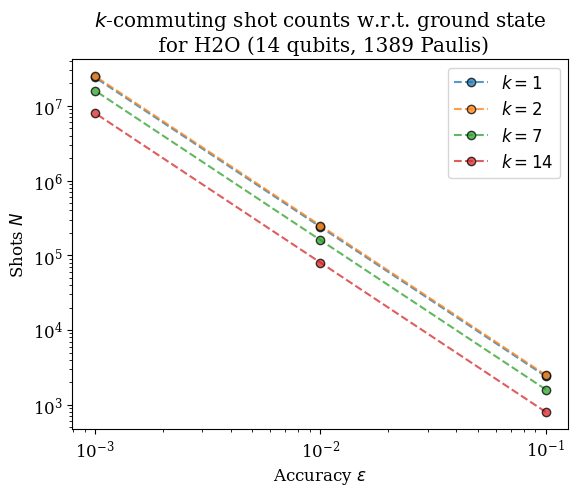

In [13]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})


for kval, shots in zip(kvals, all_shots):
    plt.loglog(epsilons, shots, "--o", alpha=0.75, mec="black", label=f"$k = {kval}$")

plt.legend()
plt.xlabel("Accuracy $\epsilon$")
plt.ylabel("Shots $N$")
plt.title(f"$k$-commuting shot counts w.r.t. ground state\n for H2O ({nqubits} qubits, {nterms} Paulis)");